# Actividad Integradora

### Daniel Emilio Fuentes Portaluppi - A01708302

# Descripción
¡Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

**Puntos a considerar**
* La semilla para generación de números aleatorios será 67890.
* El almacén es 20x20 celdas.
* Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
* Todos los robots empiezan en posiciones aleatorias vacías. * Y, sólo puede haber un robot por celda.
* La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

**¿Que debes entregar?**
* Un cuaderno de Jupyter Notebook conteniendo un reporte de la actividad. El cuaderno deberá contener:
* Código fuente documentado.
* Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
* Una visualización que permita ver los diferentes pasos de la simulación.
* El número de pasos necesarios para terminar la simulación.
* ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

**Criterios de evaluación**
<br>Los criterios que se utilizarán para evaluar sus soluciones y seleccionar a los tres primeros ganadores son los siguientes:
* Aplicación original, innovadora y efectiva de algoritmos computacionales para resolver problemas específicos.
* El rendimiento de la implementación. El rendimiento de la implementación se medirá en función los pasos necesarios para terminar la simulación.
* La calidad de la descripción de análisis, diseño e implementación del sistema multiagente, la elegancia de su diseño e implementación.


In [167]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que todos los agentes inicien en una celda, elegimos ''MultiGrid''.
from mesa.space import SingleGrid, MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete 'seaborn' para hacer gráficas más atractivas.
import seaborn as sns

In [168]:
class Organizer(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.random.seed(67890)
        self.isCarrying = False
        self.attempts = 0
        self.max_attempts = 10

    # Definimos el método ''move'' que permite a los agentes moverse a una celda vacía.
    def random_move(self):
        possible_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )

        empty_cells = [
            cell for cell in possible_cells if self.model.grid.is_cell_empty(cell)
        ]

        if empty_cells:
            new_position = self.random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)

    def carry(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        for neighbor_pos in neighbors:
            x, y = neighbor_pos
            if (self.model.boxes[x, y] == 2 or self.model.boxes[x, y] == 1) and self.isCarrying == False:
                self.model.boxes[x, y] -= 1
                self.isCarrying = True
                break
        self.random_move()

    def drop(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        for neighbor_pos in neighbors:
            x, y = neighbor_pos
            if self.model.boxes[x, y] >= 3 and self.model.boxes[x, y] < 5 and self.isCarrying:
                self.model.boxes[x, y] += 1
                self.isCarrying = False
                break

        # Si no puede dejar la caja en ninguna ubicación válida después de varios intentos, suéltela en una posición aleatoria sin 5 cajas alrededor.
        if self.isCarrying and self.attempts >= self.max_attempts:
            possible_cells = self.model.grid.get_neighborhood(
                self.pos, moore=True, include_center=False)
            empty_cells = [cell for cell in possible_cells if self.model.grid.is_cell_empty(cell) and self.model.boxes[cell[0], cell[1]] < 5]

            if empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.boxes[new_position[0], new_position[1]] += 1
                self.isCarrying = False
                self.attempts = 0

        self.attempts += 1
        self.random_move()
        

    def step(self):
        self.random_move()
        self.carry()
        self.drop()

In [169]:
def get_agents(model):
    agents = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        x, y = agent.pos
        agents[x][y] = 1
    return agents

In [170]:
class WareHouse(Model):
    def __init__(self, num_agents, width, height):
        self.random.seed(67890)
        self.grid = SingleGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height))
        self.schedule = SimultaneousActivation(self)
        self.piles = 0

        self.running = True

        reporters = {"Agents": get_agents, "Boxes": lambda m: self.boxes.copy()}

        self.datacollector = DataCollector(model_reporters=reporters)

        # Creamos los agentes en ubicaciones aleatorias.
        for i in range(num_agents):
            a = Organizer(i, self)
            self.schedule.add(a)
            
            # Intentar encontrar una celda vacía para el nuevo agente
            placed = False
            while not placed:
                x = self.random.randrange(width)
                y = self.random.randrange(height)
                if self.grid.is_cell_empty((x, y)):
                    self.grid.place_agent(a, (x, y))
                    placed = True

        # Creamos las cajas en ubicaiones aleatorias.
        num_boxes = 200
        for i in range(num_boxes):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            while self.boxes[x][y] >= 3:
                x = self.random.randrange(width)
                y = self.random.randrange(height)
            # Agregar una caja a la celda
            self.boxes[x][y] += 1

    def check_and_increment_piles(self):
        temp_piles = 0
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                if self.boxes[x][y] == 5:
                    temp_piles += 1
        return temp_piles   

    def step(self):
        self.check_and_increment_piles()
        self.piles = self.check_and_increment_piles()
        self.datacollector.collect(self)
        self.schedule.step()
        print(self.piles, self.schedule.steps, end='\r')

        if self.piles == 40:
            self.running = False
    

In [171]:
WIDTH = 20
HEIGHT = 20
N = 5

model = WareHouse(N, WIDTH, HEIGHT)

while model.running:
    model.step()

# for agent in model.schedule.agents:
#     print(agent.piles)


all_grid = model.datacollector.get_model_vars_dataframe()

In [172]:
# print total steps
print(model.schedule.steps)

165794


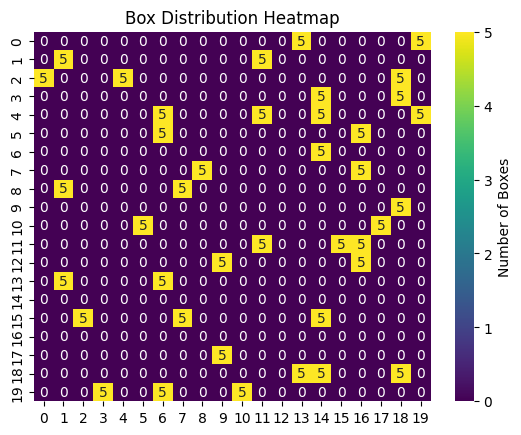

In [173]:
# Get the data for plotting
all_grid = model.datacollector.get_model_vars_dataframe()
heatmap_data = all_grid["Boxes"].iloc[model.schedule.steps - 1]  # Use the data from the last step

# Plot the heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="g",
    cmap="viridis",
    cbar_kws={"label": "Number of Boxes"},
)
plt.title("Box Distribution Heatmap")
plt.show()

In [174]:
# fig, axs = plt.subplots(figsize=(5,5))

# axs.set_xticks([])
# axs.set_yticks([])

# agents = all_grid.get('Agents')
# boxes = all_grid.get('Boxes')

# data = boxes + (4 * agents)

# patch = axs.imshow(data[0], cmap='Grays')
# plt.close()

# def animate(i):
#     patch.set_data(data[i])

# anim = animation.FuncAnimation(fig, animate, frames=model.schedule.steps, interval=100)

# anim